### L1000 Visualization

- Visualizing the median scores of all MOAs across different doses using heatmap plots

- Visualizing the p-values vs median scores in scatterplot

- Visualizing the median scores of MOAs with p-values below the significant level across all doses (1-6)

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import warnings

warnings.filterwarnings("ignore", message="Glyph 147 missing from current font.")
warnings.filterwarnings("ignore", message="Glyph 128 missing from current font.")

In [2]:
df_median_scores = pd.read_csv(os.path.join('moa_sizes_consensus_datasets', 'modz_moa_median_scores.csv'))
df_null_p_vals = pd.read_csv(os.path.join('moa_sizes_consensus_datasets', 'modz_null_p_values.csv'))

In [3]:
df_median_scores.shape

(213, 8)

In [4]:
df_null_p_vals.shape

(213, 8)

In [5]:
def plot_save_heatmap(df_moa_values, path, file_name):
    """Generate and save heatmap plot for the moa sizes dataframe based on different doses"""
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    df_moa_values = df_moa_values.set_index('moa').rename_axis(None, axis=0).drop(['moa_size'], axis=1)
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(45,45)) 
    plt.title("Variation in MOA sizes across different doses")
    sns.heatmap(df_moa_values, cmap='Reds')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

### Plots - variation in median scores of MOAs across different doses

### - Split the dataframe into 3 parts for easier visualization


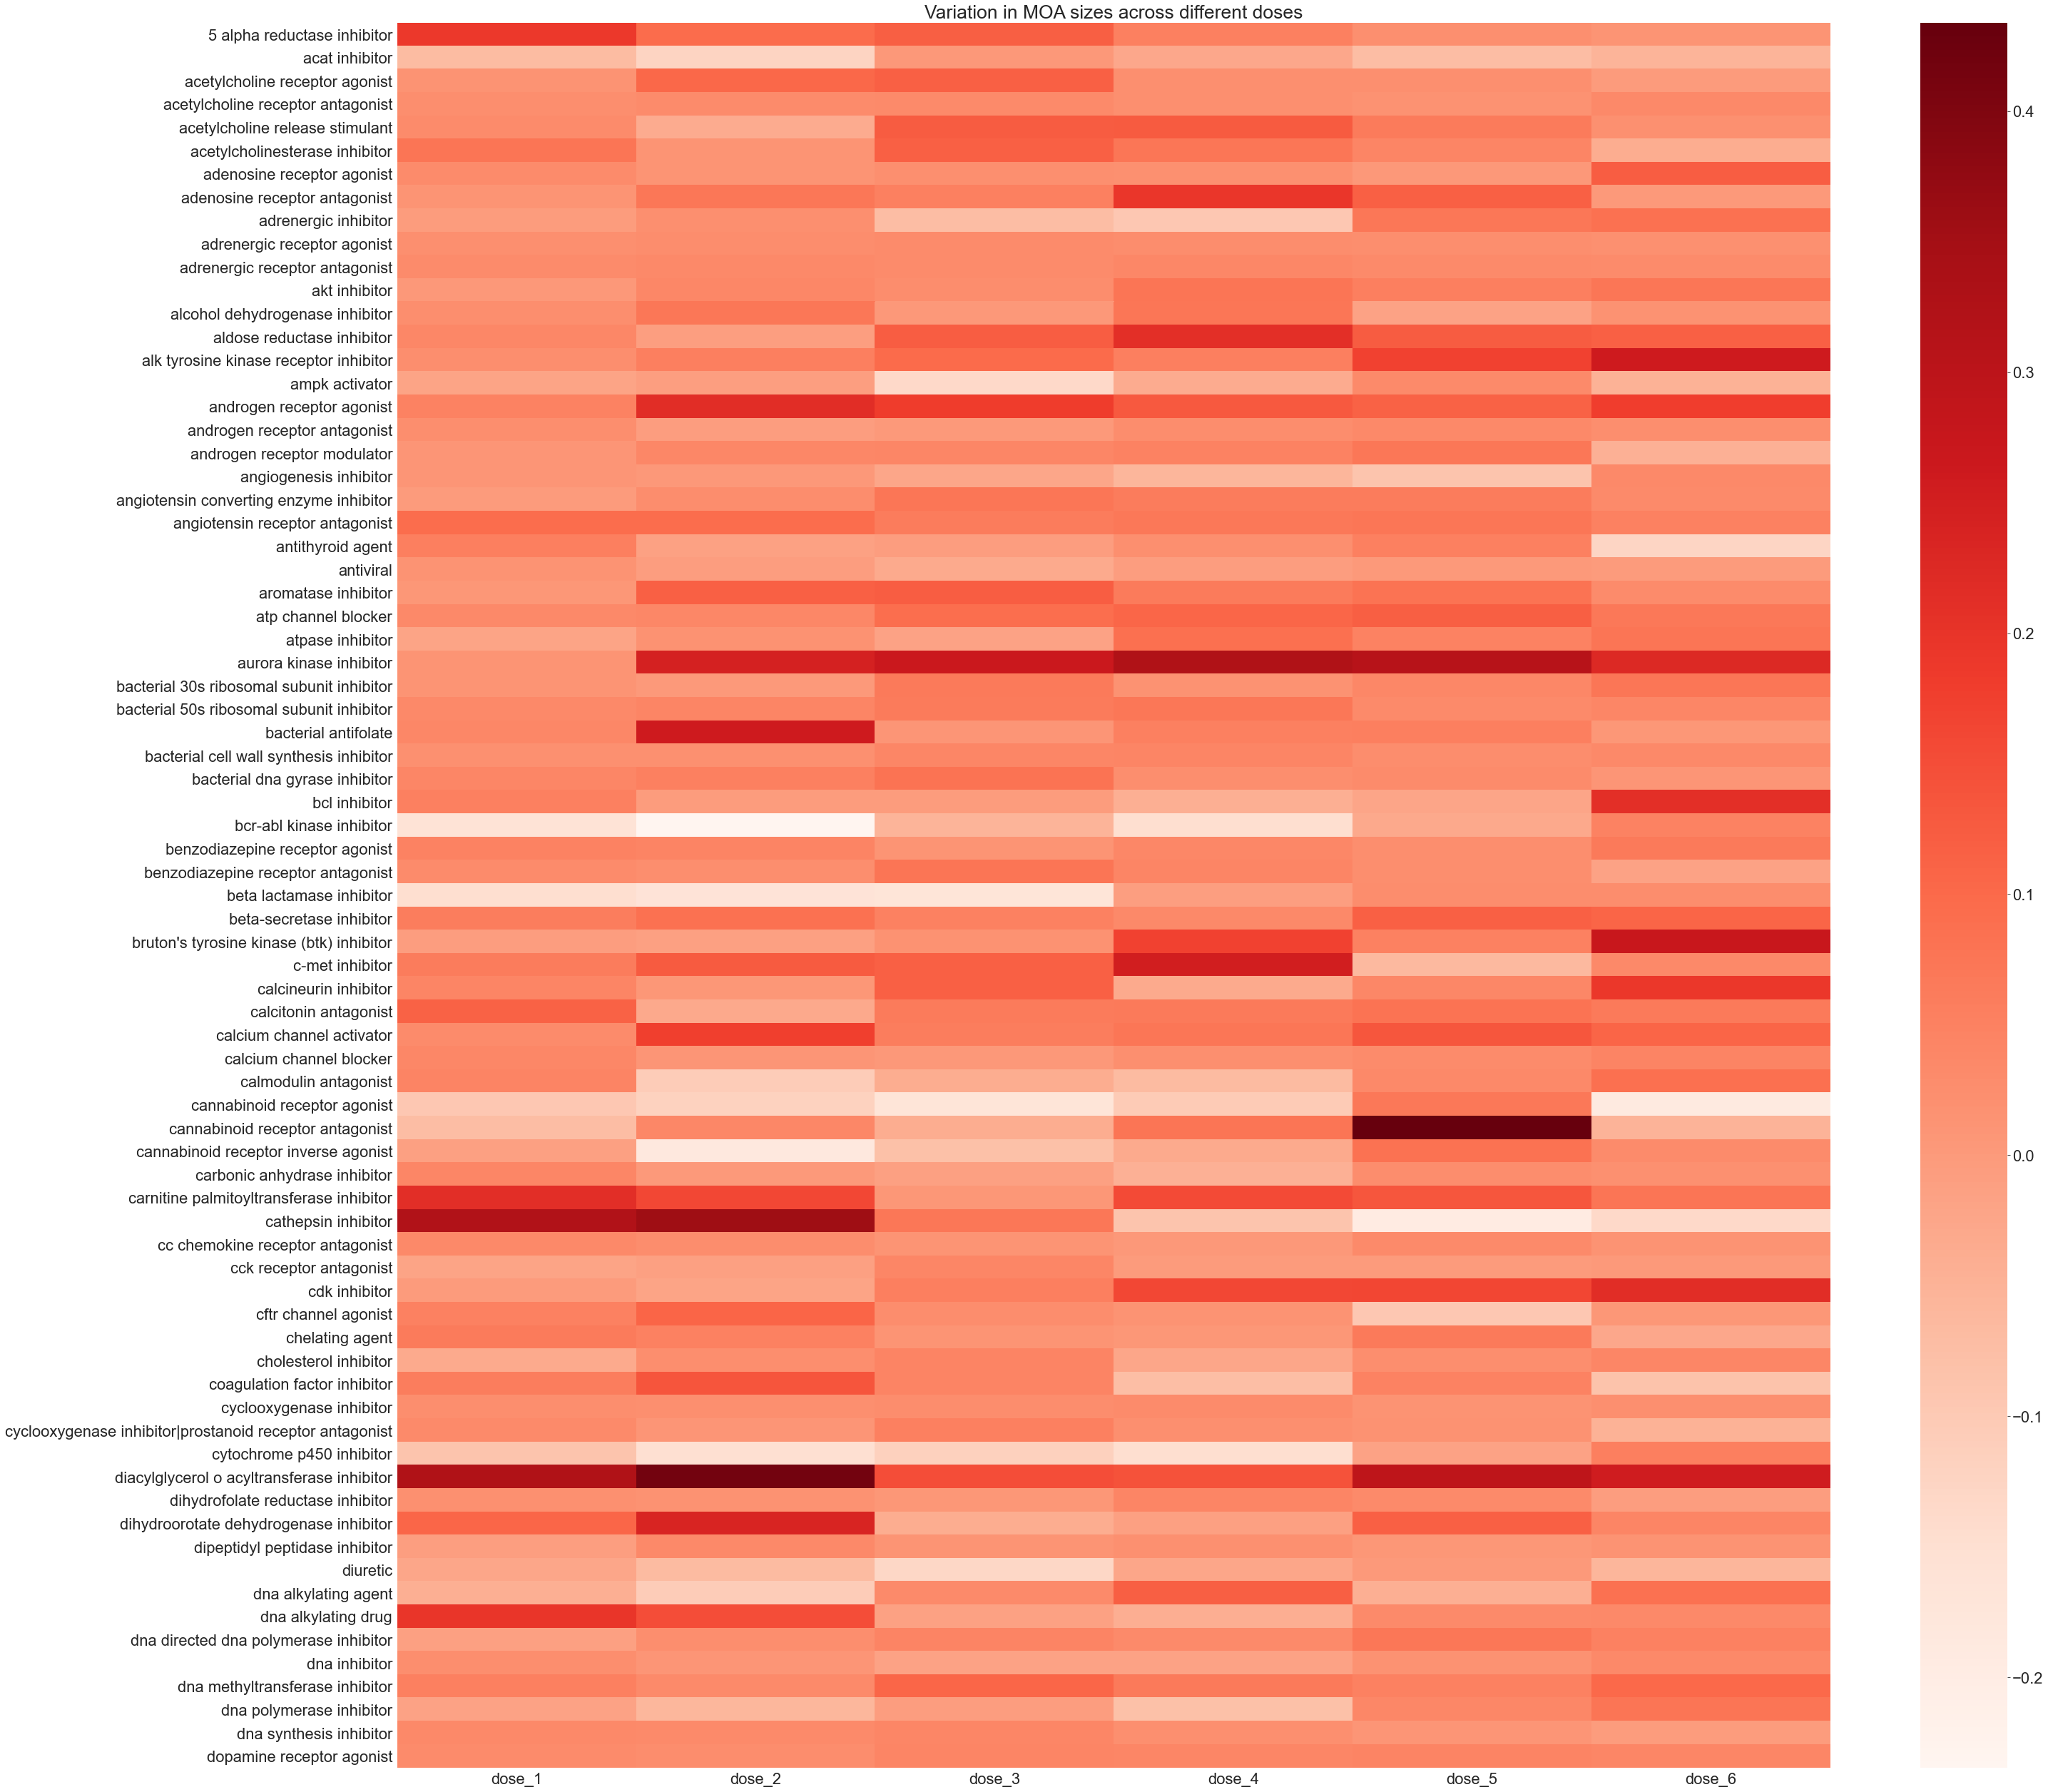

In [6]:
plot_save_heatmap(df_median_scores.iloc[:75, :], 'L1000_figures', 'modz_heatmap_1.png')

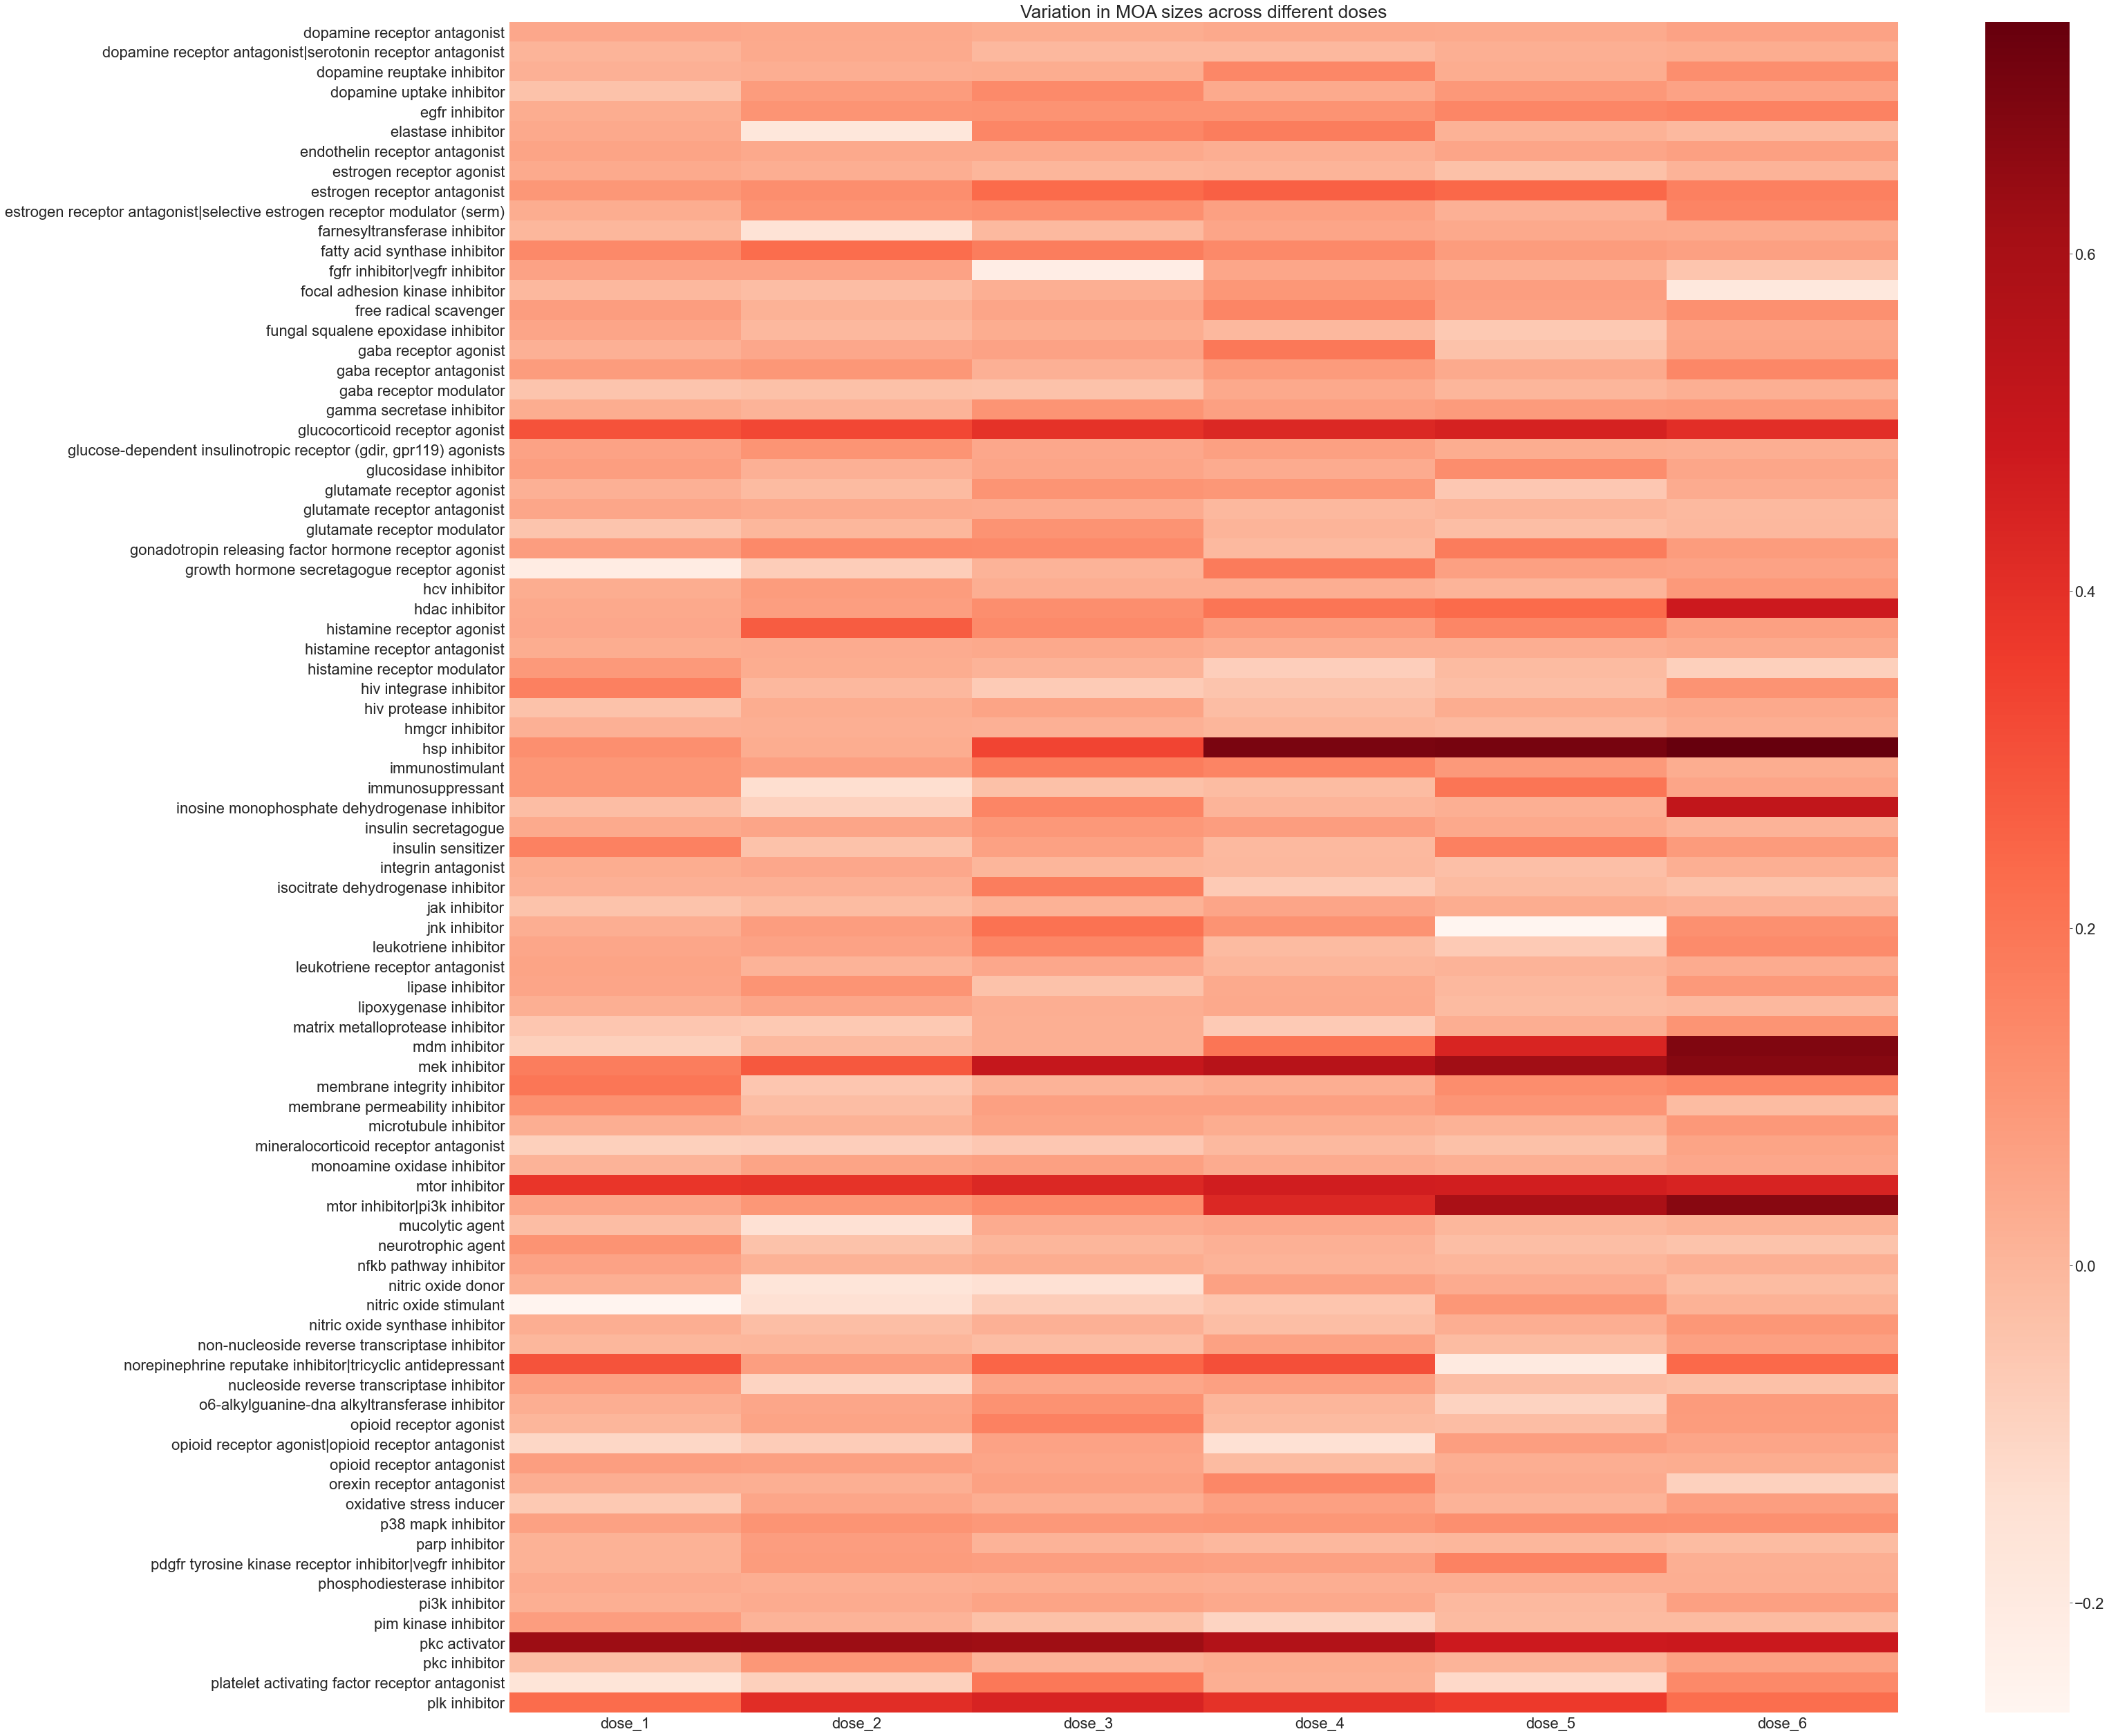

In [7]:
plot_save_heatmap(df_median_scores.iloc[75:160, :], 'L1000_figures', 'modz_heatmap_2.png')

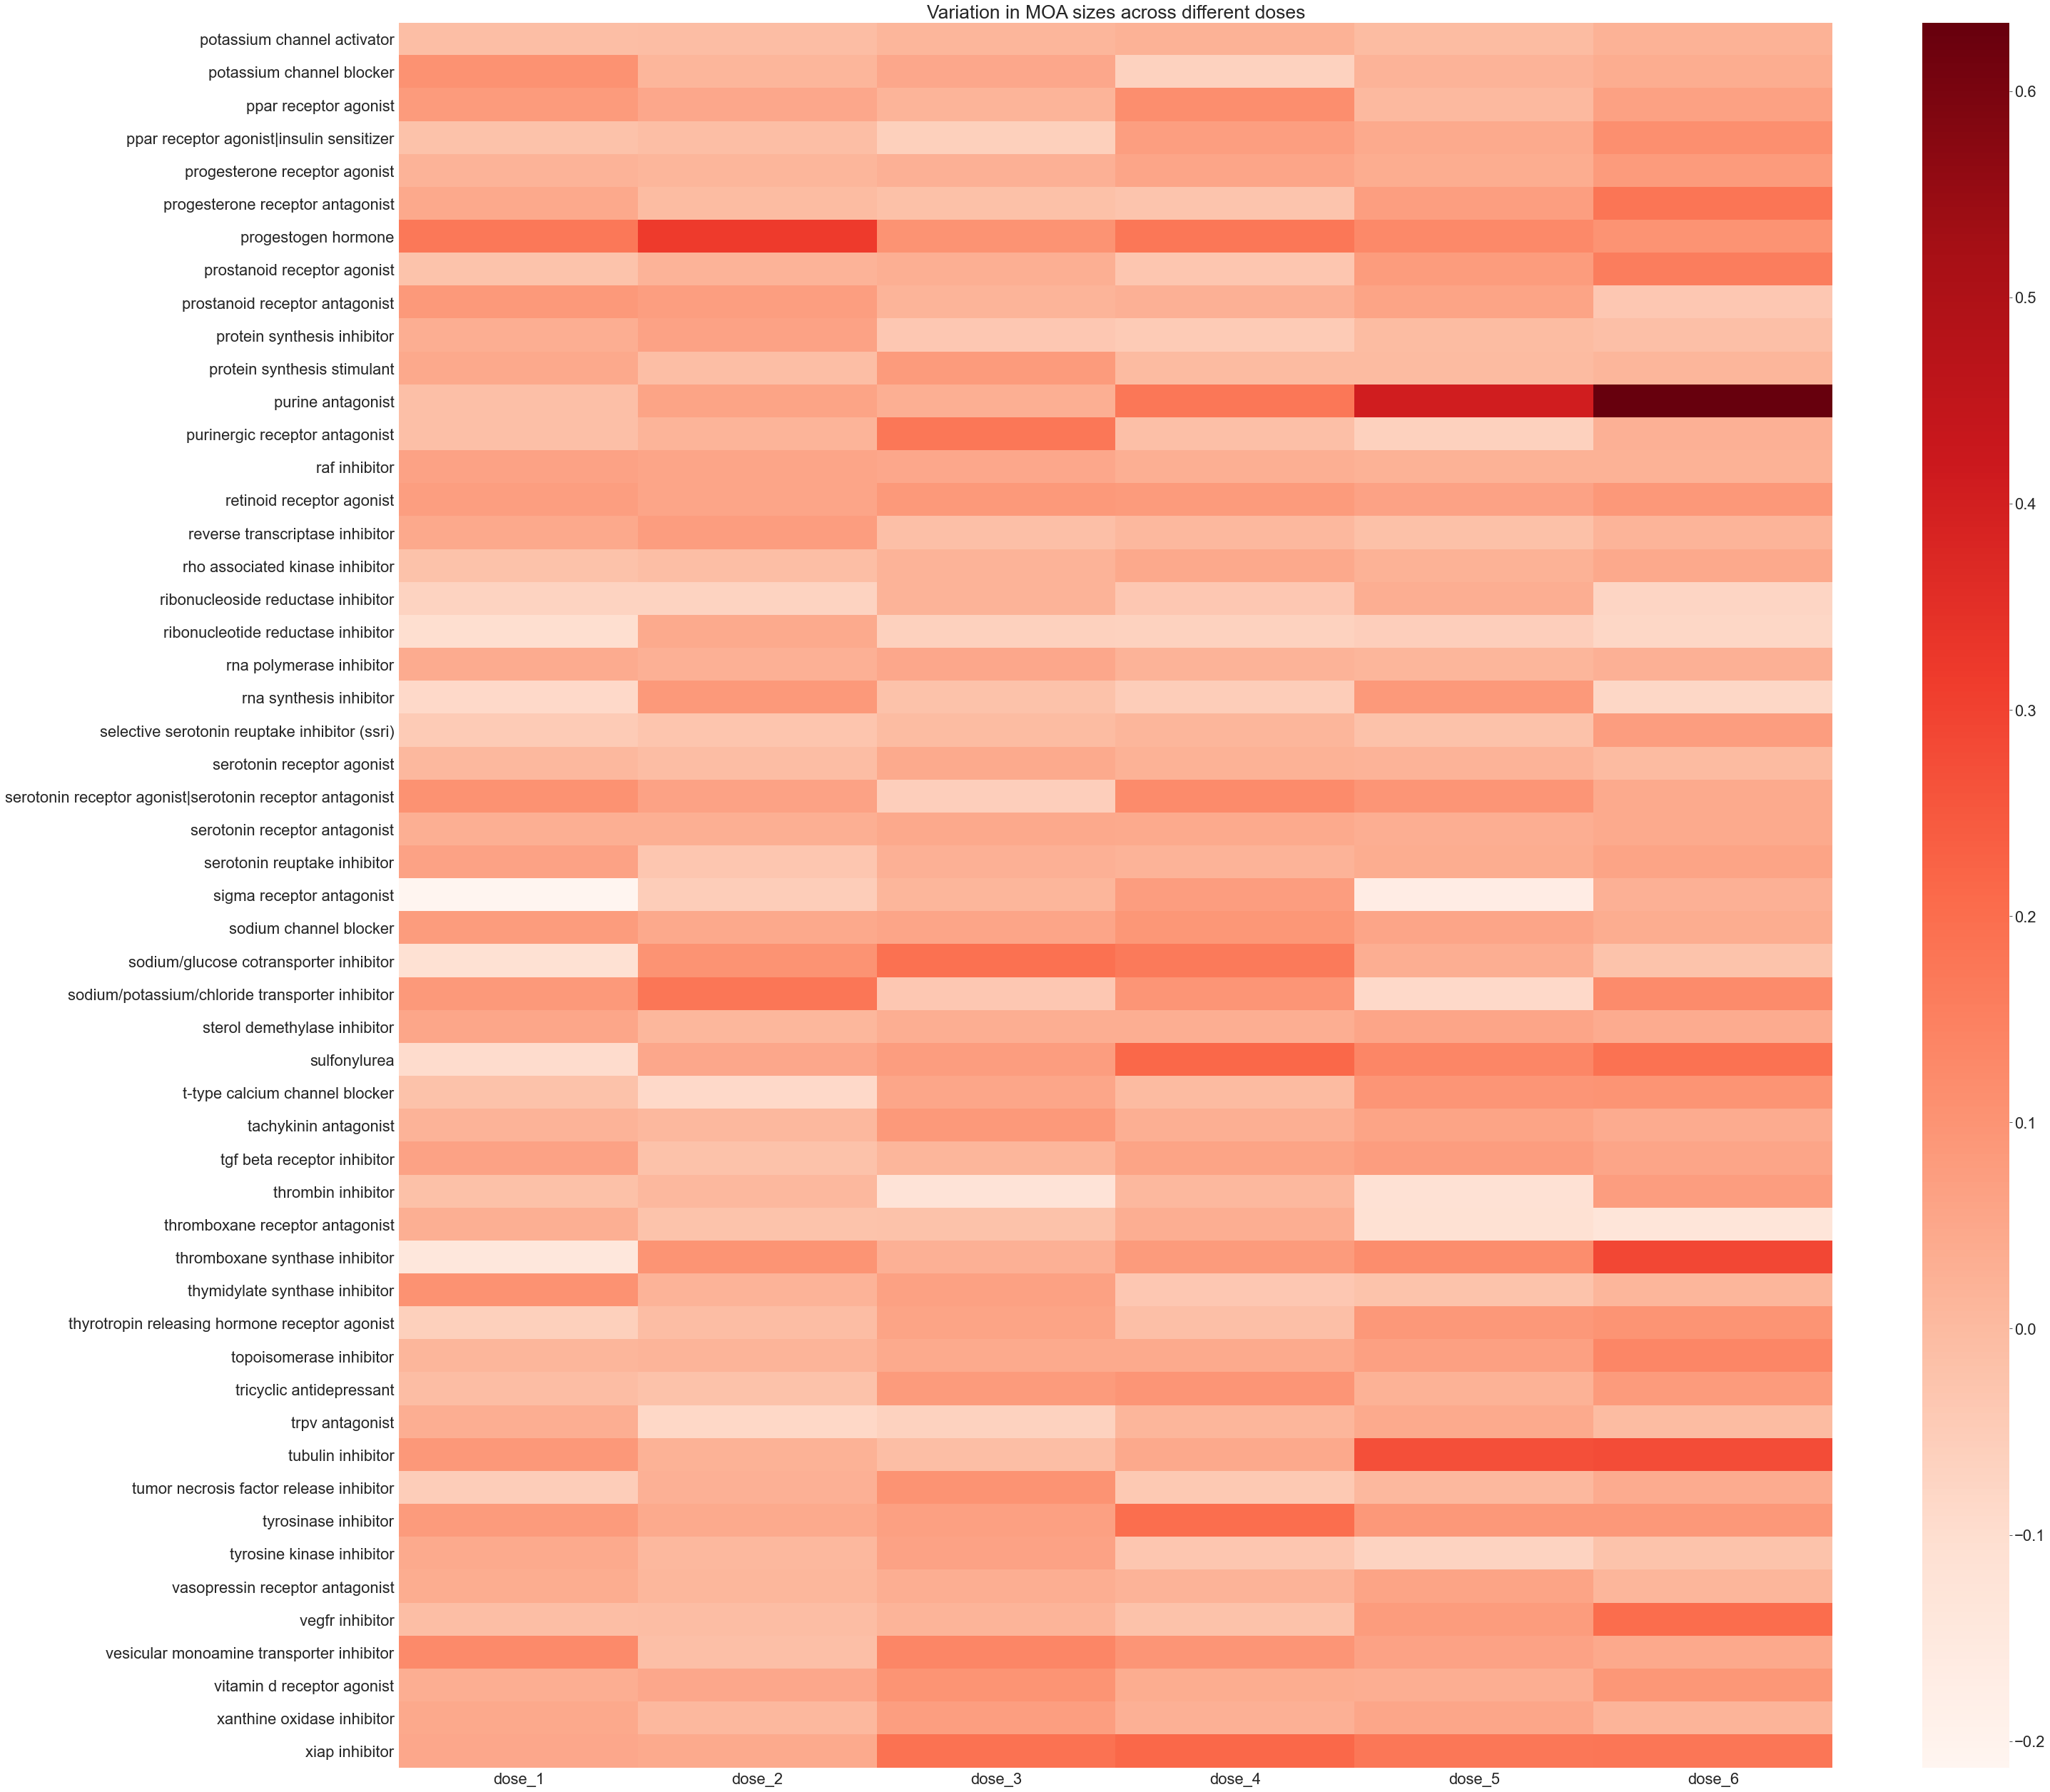

In [8]:
plot_save_heatmap(df_median_scores.iloc[160:, :], 'L1000_figures', 'modz_heatmap_3.png')

### - Visualization of p-values vs median scores for each MOAs per dose

In [9]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: MOA, dose number and dose_values(median score or p-value)
    """
    df = df.melt(id_vars=['moa', 'moa_size'], var_name="dose", value_name=col_name)
    return df

In [10]:
def merge_p_median_vals(df_moa_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each MOA for all doses(1-6) 
    """
    
    df_p_vals = melt_df(df_null, 'p_values')
    df_moa_vals = melt_df(df_moa_vals, 'median_scores')
    df_moa_vals['p_values'] = df_p_vals['p_values']
    return df_moa_vals

In [11]:
def plot_p_vs_median(df, text, file_path):
    """plot p_values vs median correlation scores for each MOA for all doses"""
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs Median scores for " + text)
    fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", style="dose")
    fig.axhline(0.03, ls='--', c='black')
    fig.text(-0.22,0.07, "Significance level (0.05)")
    plt.savefig(file_path)
    plt.show()

In [12]:
df_medians_p_vals = merge_p_median_vals(df_median_scores, df_null_p_vals)

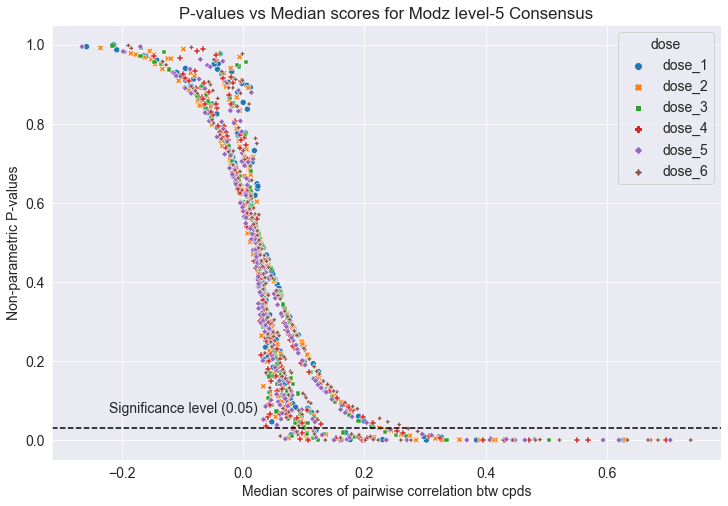

In [13]:
plot_p_vs_median(df_medians_p_vals, 'Modz level-5 Consensus', 
                 os.path.join('L1000_figures', 'modz_p_vs_medscores_plot.png'))

In [14]:
def plot_p_vs_median_jointplot(df, text, file_path):
    """plot p_values vs median correlation scores for each MOA for all doses using jointplot"""
    
    jt_plt = sns.JointGrid(height = 10, ratio = 5, xlim = (-0.5,0.8), ylim = (-0.02,1.02))
    x, y = df["median_scores"], df["p_values"]
    sns.scatterplot(x=x, y=y, ax=jt_plt.ax_joint, hue = df["dose"])
    sns.histplot(x=x, multiple="stack", hue = df["dose"], ax=jt_plt.ax_marg_x, legend=False)
    sns.histplot(y=y, multiple="stack", hue = df["dose"], ax=jt_plt.ax_marg_y, legend=False)
    jt_plt.fig.suptitle("P-values vs Median scores for " + text, size = 16)
    jt_plt.fig.subplots_adjust(top=.95)
    jt_plt.ax_joint.axhline(0.05, ls='--', c='black')
    jt_plt.ax_joint.text(-0.42,0.07, "Significance level (0.05)")
    jt_plt.set_axis_labels("Median scores of pairwise correlation btw cpds", "Non-parametric P-values")
    plt.savefig(file_path)
    plt.show()

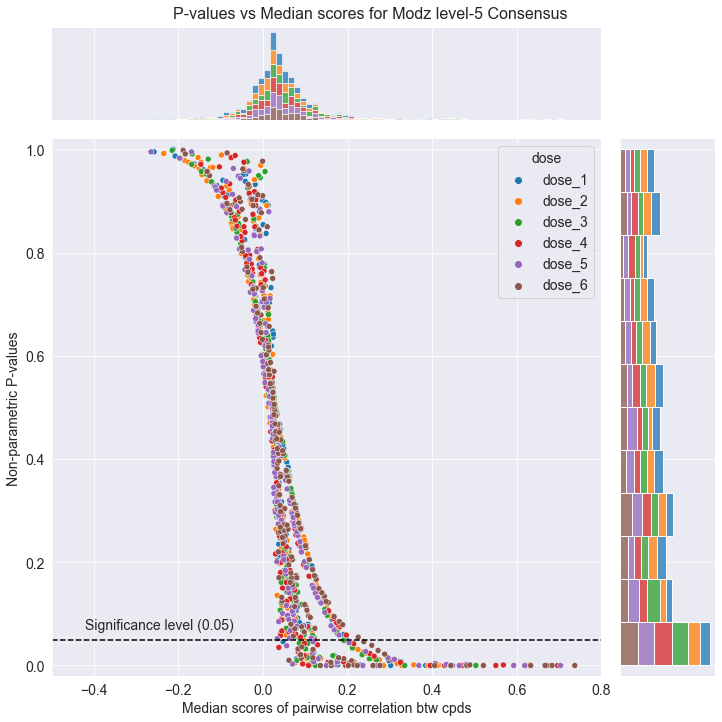

In [15]:
plot_p_vs_median_jointplot(df_medians_p_vals, 'Modz level-5 Consensus', 
                           os.path.join('L1000_figures', 'modz_p_vs_medscores_jointplot.png'))

### - Visualize the MOAs with p-values below the significant level (0.05)


- These are MOAs with less than (0.05) 5% probability or chance of obtaining random median correlation score from the null distribution that is greater than or equal to their own median correlation score; (**Assuming** median score generated from randomly selected cpds of different moas are greater than those of the same MOAs).

In [16]:
def stat_significant_MOAs(df_p_values):
    """
    This function return MOAs with less than (0.05) 5% probability of 
    obtaining random median correlation score from the null distribution that is 
    greater than or equal to their own median correlation score all doses(1-6)
    """
    df_p_values = df_p_values.set_index('moa').rename_axis(None, axis=0).drop(['moa_size'], axis = 1)
    p_moas = [moa for moa in df_p_values.index 
                 if all(df_p_values.loc[moa].values < 0.05)]
    return df_p_values.loc[p_moas]

In [17]:
df_sign_moas = stat_significant_MOAs(df_null_p_vals)

In [18]:
df_sign_moas ##p-values(<0.05) for different MOAs across all doses

,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6
glucocorticoid receptor agonist,0.000,0.000,0.0,0.000,0.000,0.000
mek inhibitor,0.001,0.000,0.0,0.000,0.000,0.000
mtor inhibitor,0.000,0.000,0.0,0.000,0.000,0.000
pkc activator,0.000,0.001,0.0,0.001,0.002,0.001
plk inhibitor,0.001,0.000,0.0,0.000,0.000,0.000


In [19]:
def plot_significant_moas(df_sign_moas, df_moa_vals, file_path):
    """Plot of median scores for MOAs with p-values below the significant level"""
    
    df_moa_vals = df_moa_vals.set_index('moa').rename_axis(None, axis=0)
    df_significant_moas = df_moa_vals.loc[df_sign_moas.index]
    df_significant_moas = df_significant_moas.reset_index().rename(columns={"index": "moa"})
    
    sns.relplot(data=df_significant_moas, x="dose", y="median_scores", col="moa", 
                kind="line", col_wrap=3, height=3.5, aspect=1.5, 
                facet_kws=dict(sharex=False))
    plt.savefig(file_path)
    plt.show()

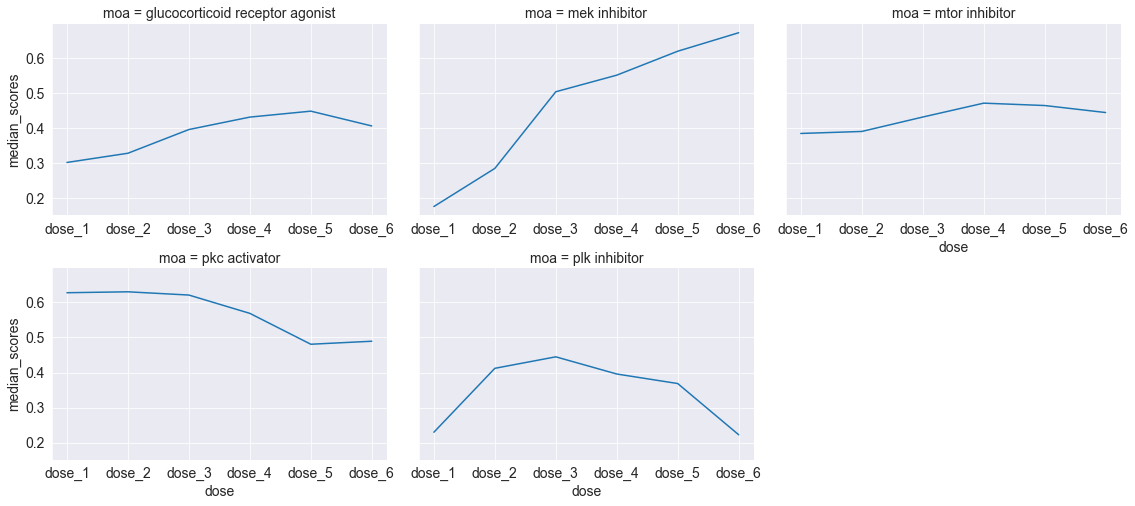

In [20]:
plot_significant_moas(df_sign_moas, df_medians_p_vals, 
                      os.path.join('L1000_figures', 'modz_sign_moa_medscores_plot.png'))